# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

Femke Geens - 0544174 - VUB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy
import math
import statistics

from scipy.special import comb
from scipy.interpolate import interp1d

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

# Figure 1
To successfully replicate figures 1.A. and 1.B., we construct the environment of the N-person Hawk-Dove Game. For this particular game, we analyze the environment for infinite populations.

In [12]:
R = 1.0
N = 5
n_steps = 300

In [3]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D

In [4]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness

# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)

Next, we generate the results to obtain figure 1.A.. This figure illustrates the gradient of selection for different frequencies of doves in the population. To do this for infinite populations, we repeatedly take a sample of size N and perform our calculations using this sample. In this case the sample size is 5. The gradient is displayed for varying hawk costs. This enables us to reason about the stability of the doves in the population when hawks are punished to a varying degree.

In [5]:
c_h_results = np.empty((3, n_steps))
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

for index, c_h in enumerate([0.1, 0.5, 0.9]):

    x_dot = np.empty(n_steps)

    for i in range(len(hawk_cost)):
        x = hawk_cost[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

    c_h_results[index] = x_dot

Further, we generate the data to correctly reproduce figure 1.B.. To obtain these results, we explore the different frequencies of doves to find where the population reaches an equilibrium for increasing hawk costs. We repeat this for different sample sizes 5, 10, 20, 50, and 100 to see how the equilibria shift.

In [13]:
import statistics

dove_fractions = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))
PRECISION = 1e-03

for i_N, N in enumerate(N_values):
    equilibria_N = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        eq_fraction = []
        x_dot = np.empty(n_steps)

        for i in range(len(dove_fractions)):
            x = dove_fractions[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

            if abs(fitness_doves - fitness_hawks) < PRECISION:
                eq_fraction.append(x)
                if x != 0.0:
                     break

        if 0 in eq_fraction:
            eq_fraction.remove(0)
        if (n_steps - 1) in eq_fraction:
            eq_fraction.remove((n_steps - 1))
        if eq_fraction:
            equilibria_N.append(statistics.median(eq_fraction))
        else:
             equilibria_N.append(np.nan)

    eq_results[i_N] = equilibria_N

Now, we plot figure 1.A. and figure 1.B. next to each other to successfully replicate figure 1 from the paper.

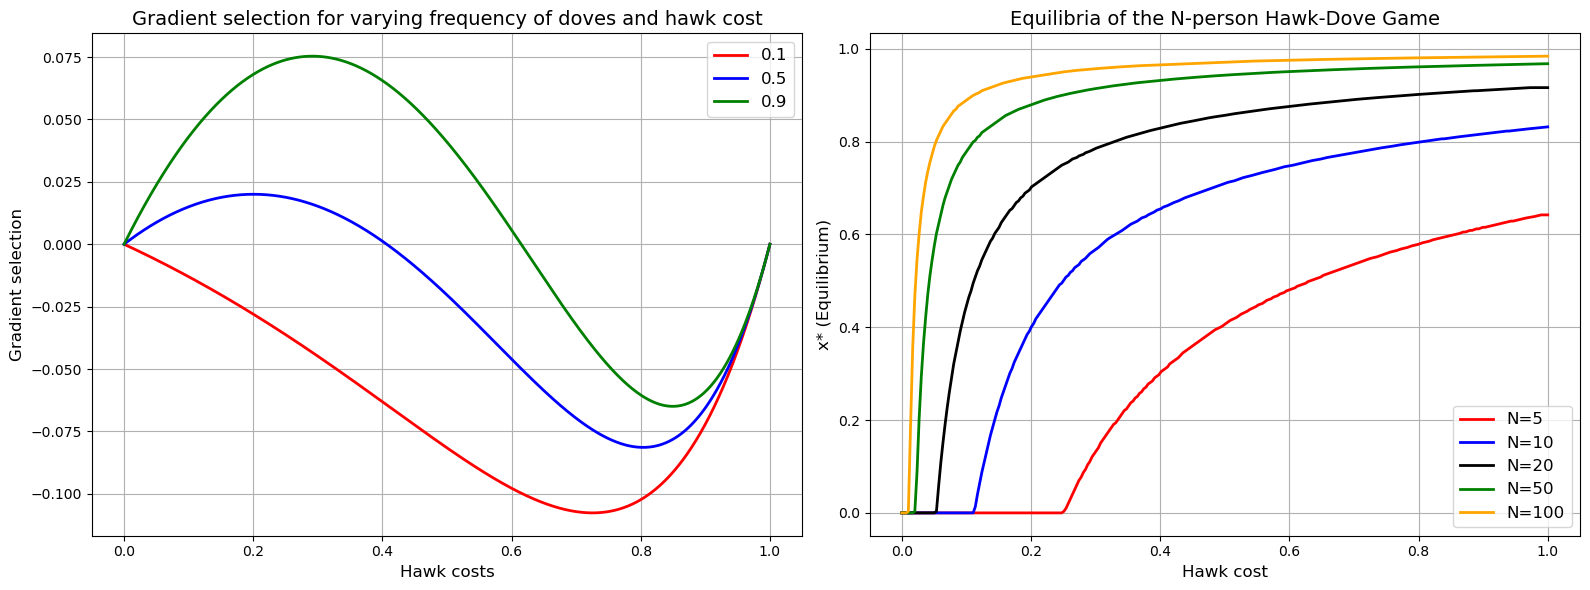

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First Plot
labels_1 = ["0.1", "0.5", "0.9"]
colors_1 = ["red", "blue", "green"]

for i, values in enumerate(c_h_results):
    axes[0].plot(hawk_cost, values, label=labels_1[i], color=colors_1[i], linewidth=2)

axes[0].set_xlabel("Hawk costs", fontsize=12)
axes[0].set_ylabel("Gradient selection", fontsize=12)
axes[0].set_title("Gradient selection for varying frequency of doves and hawk cost", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# Second Plot
labels_2 = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors_2 = ["red", "blue", "black", "green", "orange"]

for i, values in enumerate(eq_results):
    x = np.linspace(0, 1, num=len(values), dtype=np.float64)
    first_valid_index = np.where(~np.isnan(values))[0][0]
    values[:first_valid_index] = 0

    valid = ~np.isnan(values)
    interp_func = interp1d(x[valid], values[valid], kind='linear', fill_value="extrapolate")
    values[~valid] = interp_func(x[~valid])

    axes[1].plot(x, values, label=labels_2[i], color=colors_2[i], linewidth=2)

axes[1].set_xlabel("Hawk cost", fontsize=12)
axes[1].set_ylabel("x* (Equilibrium)", fontsize=12)
axes[1].set_title("Equilibria of the N-person Hawk-Dove Game", fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Figure 2

### avg_fitness_hawks
The avg_fitness_hawks function will calculate the payoff of the hawks for a finit population. The function takes the following arguments: the fraction of the doves (k), the sample size (N), the cost of the hawks ($c_h$) and the population sizes (Z).

### avg_fitness_doves
The avg_fitness_doves function will calculate the payoff of the doves for a finit population. The function takes the following arguments: the fraction of the doves (k), the sample size (N) and the population sizes (Z).

In [2]:
def avg_fitness_hawks(k, N, cost_hawks, Z): 

  #Function to calculate the payoff of the hawks.
  def payoff_hawks(nr_doves):
    nr_hawks = N - nr_doves
    if nr_doves != N :
       payoff = (R - ((nr_hawks - 1) * cost_hawks)) / nr_hawks
       return payoff
    else: return 0

  sum = 0
  #Calculate the fitness of the hawks.
  for i in range(N):
    numerator = comb(k, i) * comb(Z-k-1, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_hawks(i)
  return sum


def avg_fitness_doves(k, N, Z): 
  #Function to calculate the payoff of the doves.
  def payoff_doves(nr_doves):
    if nr_doves == N : 
       payoff = R / nr_doves
       return payoff
    else: return 0

  sum = 0
  #Calculate the fitness of tha doves.
  for i in range(N):
    numerator = comb(k-1, i) * comb(Z-k, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_doves(i+1)
  return sum

### Calculate_gradient
The Calculate_gradient function will calculate the gradient of the selection for a finit population. The function takes the following arguments: the fraction of the doves (k), the population sizes (Z), the cost of the hawks ($c_h$), the sample size (N) and the noise (w). The function will calculate the gradient based on the probabilities that the finite population will increases or decreases.


### calculate_gradients_figure_2A
The function calculate_gradients_figure_2A will calculate the x- and y-as for the plot for figure 2.A. The function takes the following arguments: the population sizes (Z), the cost of the hawks ($c_h$), the sample size (N) and the noise (w). The X-as is equal to the fraction of the doves divided by the population sizes ($\frac{k}{Z}$) The Y-as is equal to the gradient of the selection.

In [7]:
def Calculate_gradient(k, Z, c_H, N, w): 

    fraction = k/Z

    #Calculate the fitness of the doves.
    doves_fitness = avg_fitness_doves(k, N, Z)

    #Calculate the fitness of the hawks.
    hawks_fitness = avg_fitness_hawks(k, N, c_H, Z)

    #Calculate the numerator fot the T_plus and T_minus.
    numerator = ((Z - k) / Z)
    
    #Calculate the denominator for the T_plus.
    denominator_T_plus = 1 / (1 + math.e**(-w * (doves_fitness - hawks_fitness)))

    #Calculate the denominator for the T_minus.
    denominator_T_minus = 1 / (1 + math.e**(w * (doves_fitness - hawks_fitness)))

    #Calculate the probabilities that the population will increase.
    T_plus = fraction * numerator * denominator_T_plus 

    #Calculate the probabilities that the population will decreases.
    T_minus = fraction * numerator * denominator_T_minus 

    #Calculate the gradient.
    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):

    #Define the k_values, this will represent the different fractions of the doves.
    k_values = np.linspace(0, Z, Z + 1, dtype=int)

    #Setup the gradient values. 
    g_values = np.empty(len(k_values))

    #Calculate for each value from k_values the gradient and store it in the g_values. 
    for i, k in enumerate(k_values):
        g_values[i] = Calculate_gradient(k, Z, c_H, N, w)

    #Calculate the X-as for the plot.
    X_as = np.linspace(0, 1, Z + 1)

    return X_as, g_values

Next, we define the functions to generate the results for figure 2.B.

### calculate_gradients_figure_2B
The function calculate_gradients_figure_2B will calculate the x- and y-as for the plot for figure 2.B. The function takes the following arguments: the population sizes (Z), the sample size (N) and the noise (w). The function will calculate the equilibrias over a range of $c_H$ values.

In [9]:
def calculate_gradients_figure_2B(Z, N, w):
    #A list where we keep track of all equilbria
    eq = []

    #Define the precision
    PRECISION = 1e-05

    #Iterate over a range of c_H values.
    for index, c_H in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)

        eq_c_h = []

        for i, gradient in enumerate(g_values):
            if gradient < PRECISION:
                frequency = X_as[i]
                eq_c_h.append(frequency)
                if frequency != 0.0:
                    break

        if 0 in eq_c_h:
            eq_c_h.remove(0)
        if (n_steps - 1) in eq_c_h:
            eq_c_h.remove((n_steps - 1))
        #If we have found an equiblria then we calculate the median.  
        if eq_c_h:
            eq.append(statistics.median(eq_c_h))

        #If we did not find equiblria, we give NAN.    
        else:
             eq.append(np.nan)

    return eq

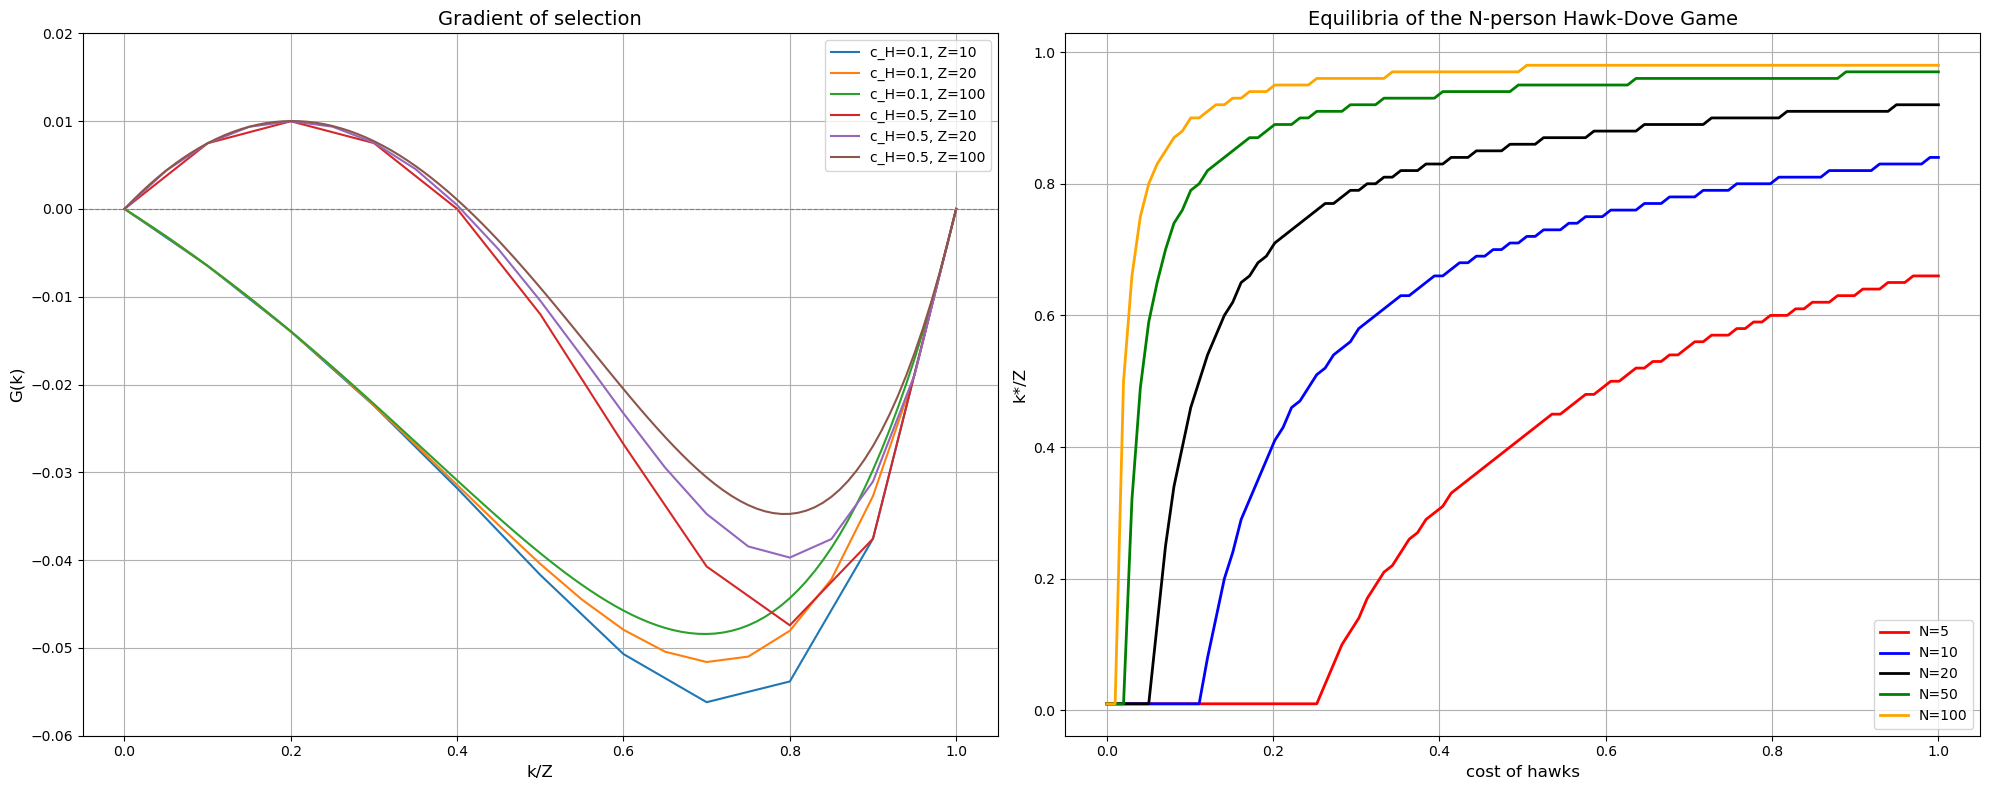

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

#Define the parameters for figure 2.A
R = 1
N = 5
cost_of_hawks_values = [0.1, 0.5]
population_size_values = [10, 20, 100]
w = 1
n_steps = 100

#Calculate the x-as en y-as for figure 2.A
for c_H in cost_of_hawks_values:
    for Z in population_size_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        axes[0].plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

#Plot details for figure 2.A
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_xlabel("k/Z", fontsize=12)
axes[0].set_ylim(-0.06, 0.02)
axes[0].set_ylabel("G(k)", fontsize=12)
axes[0].set_title("Gradient of selection", fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid()

#Define the parameters for figure 2.B
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]
N_values = [5, 10, 20, 50, 100]

Z = 100
R = 1
w = 1
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

#Calculate the x-as en y-as for figure 2.B
for i, N in enumerate(N_values):
    values = calculate_gradients_figure_2B(Z, N, w)
    axes[1].plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

# Plot details for figure 2.B
axes[1].set_xlabel("cost of hawks", fontsize=12)
axes[1].set_ylabel("k*/Z", fontsize=12)
axes[1].set_title("Equilibria of the N-person Hawk-Dove Game", fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Figure 3

In [11]:
#Define the Parameters for figure 3
N = 5
R = 1.0
n_steps = 100

### P_H_T
The function P_H_T will calculate the payoff of the hawks for infinite populations in a HDG-T model. The function takes the following arguments: the amount doves (amount_doves), the cost of the hawks ($c_h$), the threshold (T) and the sample size (N).

### P_D_T
The function P_D_T will calculate the payoff of the doves for infinite populations in a HDG-T model. The function takes the following arguments:  the amount doves (amount_doves), the cost of the doves ($c_d$), the threshold (T) and the sample size (N).

In [12]:
# Payoff of the hawks in a HDG-T
def P_H_T(amount_doves, c_h, T, N):
    P_H = 0

    #Calculate the amout of hawks
    amount_hawks = N - 1 - amount_doves

    #Calculate the total amount of hawks
    total_hawks = amount_hawks + 1

    #When the frequency of doves is lower the threshold, then calculate the payoff the hawks.
    if amount_doves/N < T:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff of the doves in a HDG-T
def P_D_T(amount_doves, c_d,  T, N):
    P_D = 0

    #Calculate the amout of hawks
    amount_hawks = N - amount_doves

    #When the frequency of doves is higher the threshold, then calculate the payoff the doves.
    if amount_doves/N >= T:
        P_D = (R - (amount_hawks * c_d)) / amount_doves
    return P_D

### average_fitness_hawks
The function average_fitness_hawks will calculate the fitness of the hawks for infinite populations in a HDG-T model. The function takes the following arguments: the sample size (N), the fractions of the doves (x_fraction), the cost of the hawks ($c_h$) and the threshold (T).


### average_fitness_doves
The function average_fitness_doves will calculate the fitness of the doves for infinite populations in a HDG-T model. The function takes the following arguments: the sample size (N), the fractions of the doves (x_fraction), the cost of the  doves ($c_d$) and the threshold (T).

In [13]:
# Fitness of the hawks in a HDG-T
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    #Calculate the fitness of the hawks.
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H_T(i, c_h, T, N)
    return average_fitness
    
# Fitness of the doves in a HDG-T
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    #Calculate the fitness of the doves.
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D_T(i+1, c_d, T, N)
    return average_fitness

### find_equilibria_indexes
The function find_equilibria_indexes calculate the equilibrias. The function takes as arguments array of gradient of selection.

In [14]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

### figure3A
The function figure3A will calculate the x-as and y-as for the plot for figure 3.A. The function takes the following arguments: the threshold (T) and the cost of doves ($c_d$). The Y-as is equal to the fraction of doves with an equilbria. The X-as is equal to the cost of the hawks.


### figure3B
The function figure3B will calculate the x-as and y-as for the plot for figure 3.B. The function takes the following arguments: the threshold (T) and the cost of hawks ($c_h$). The Y-as is equal to the fraction of doves with an equilbria. The X-as is equal to the cost of the doves.

In [15]:
def figure3A(T, c_d):

    #Define a range of hawks costs.
    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    #Define a range of doves frequencies.
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    #Setup an empyt list for dove fractions with an equilbria.
    fraction_dove = []

    #Setup an empyt list for all the costs of the hawks.
    hawk_cost_answer = []

    #Iterate over the hawks cost.
    for c_h in hawk_cost:
        x_dot = np.empty(n_steps)

        #Iterate over the dove frequencies.
        for i, x in enumerate(dove_frequency):

            #Calculate the fitness of the doves
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            #Calculate the fitness of the hawks
            fitness_hawks = average_fitness_hawks(N, x, c_h, T)
            #Calculate and store the gradient of selection
            x_dot[i] = x * (1 - x) * (fitness_doves - fitness_hawks)

        #Find the equilibrias
        equilibria = find_equilibria_indexes(x_dot) 
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        hawk_cost_answer.extend([c_h] * len(equilibria))

    return fraction_dove, hawk_cost_answer


def figure3B(T, c_h):

    #Define a range of hawks costs.
    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    #Define a range of doves frequencies.
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)

    #Setup an empyt list for dove fractions with an equilbria.
    fraction_dove = []

    #Setup an empyt list for all the costs of the doves.
    dove_cost_answer = []

    #Iterate over the hawks cost.
    for c_d in dove_cost:
        x_dot =  np.empty(n_steps)

        #Iterate over the dove frequencies.
        for i, x in enumerate(dove_frequency):
            
            #Calculate the fitness of the doves
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            #Calculate the fitness of the hawks
            fitness_hawks = average_fitness_hawks(N, x, c_h, T)
            #Calculate and store the gradient of selection
            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        #Find the equilibrias
        equilibria = find_equilibria_indexes(x_dot) 
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        dove_cost_answer.extend([c_d] * len(equilibria))

    return fraction_dove, dove_cost_answer

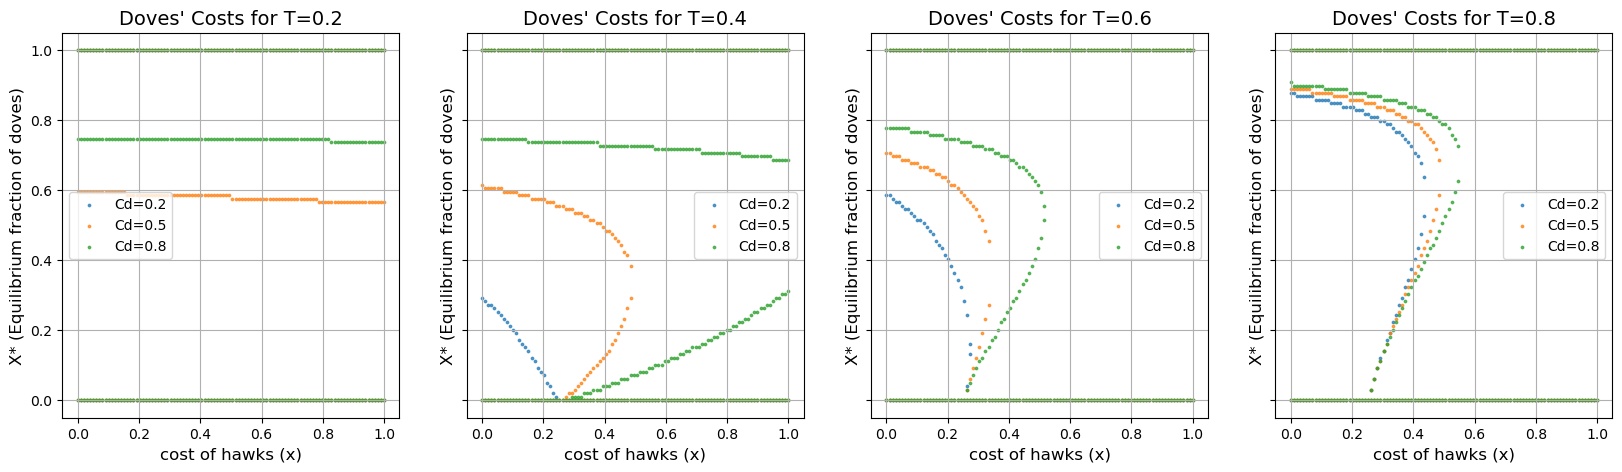

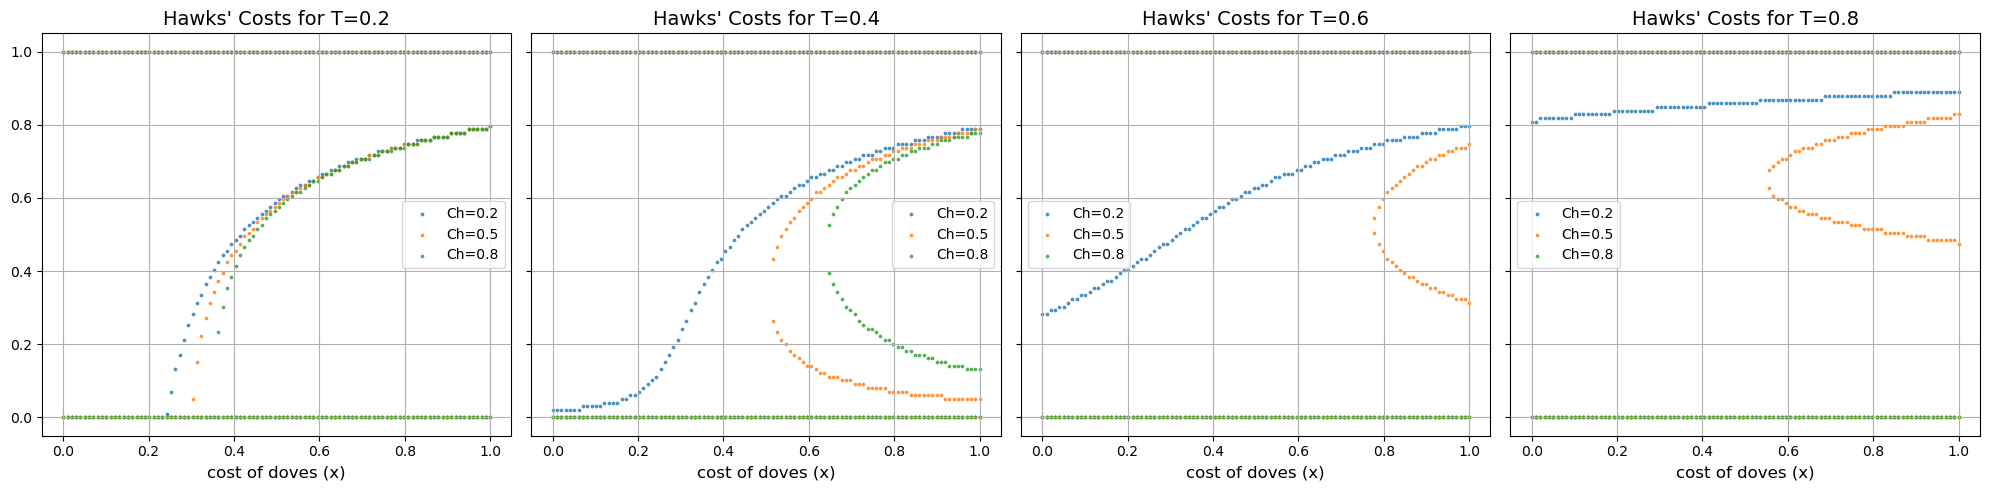

In [16]:
#Define the labels and the parameters
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

#The function plot_figure3_side_by_side will plot figure 3
def plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):
    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)

    #Iterate over the threshols values. 
    for t_idx, T in enumerate(T_values):
        
        #Calculate the x-as en y-as for figure 3.A
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure3A(T, c_d)
            axes[t_idx].scatter(x_as, y_as, label=Doves_Costs_labels[d_idx], alpha =0.7, s=3)
            
        #Plot details for figure 3.A    
        axes[t_idx].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of hawks (x)", fontsize=12)
        axes[t_idx].set_ylabel("X* (Equilibrium fraction of doves)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True) 


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)

    #Iterate over the threshols values. 
    for t_idx, T in enumerate(T_values):

        #Calculate the x-as en y-as for figure 3.B
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure3B(T, c_h)  
            axes[t_idx].scatter(x_as, y_as, label=Hawks_Costs_labels[h_idx], alpha =0.7, s=3)

        #Plot details for figure 3.B
        axes[t_idx].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of doves (x)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)    

    plt.tight_layout()
    plt.show()

plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)

# Figure 4
Phase diagram for Hawk-Dove Game.

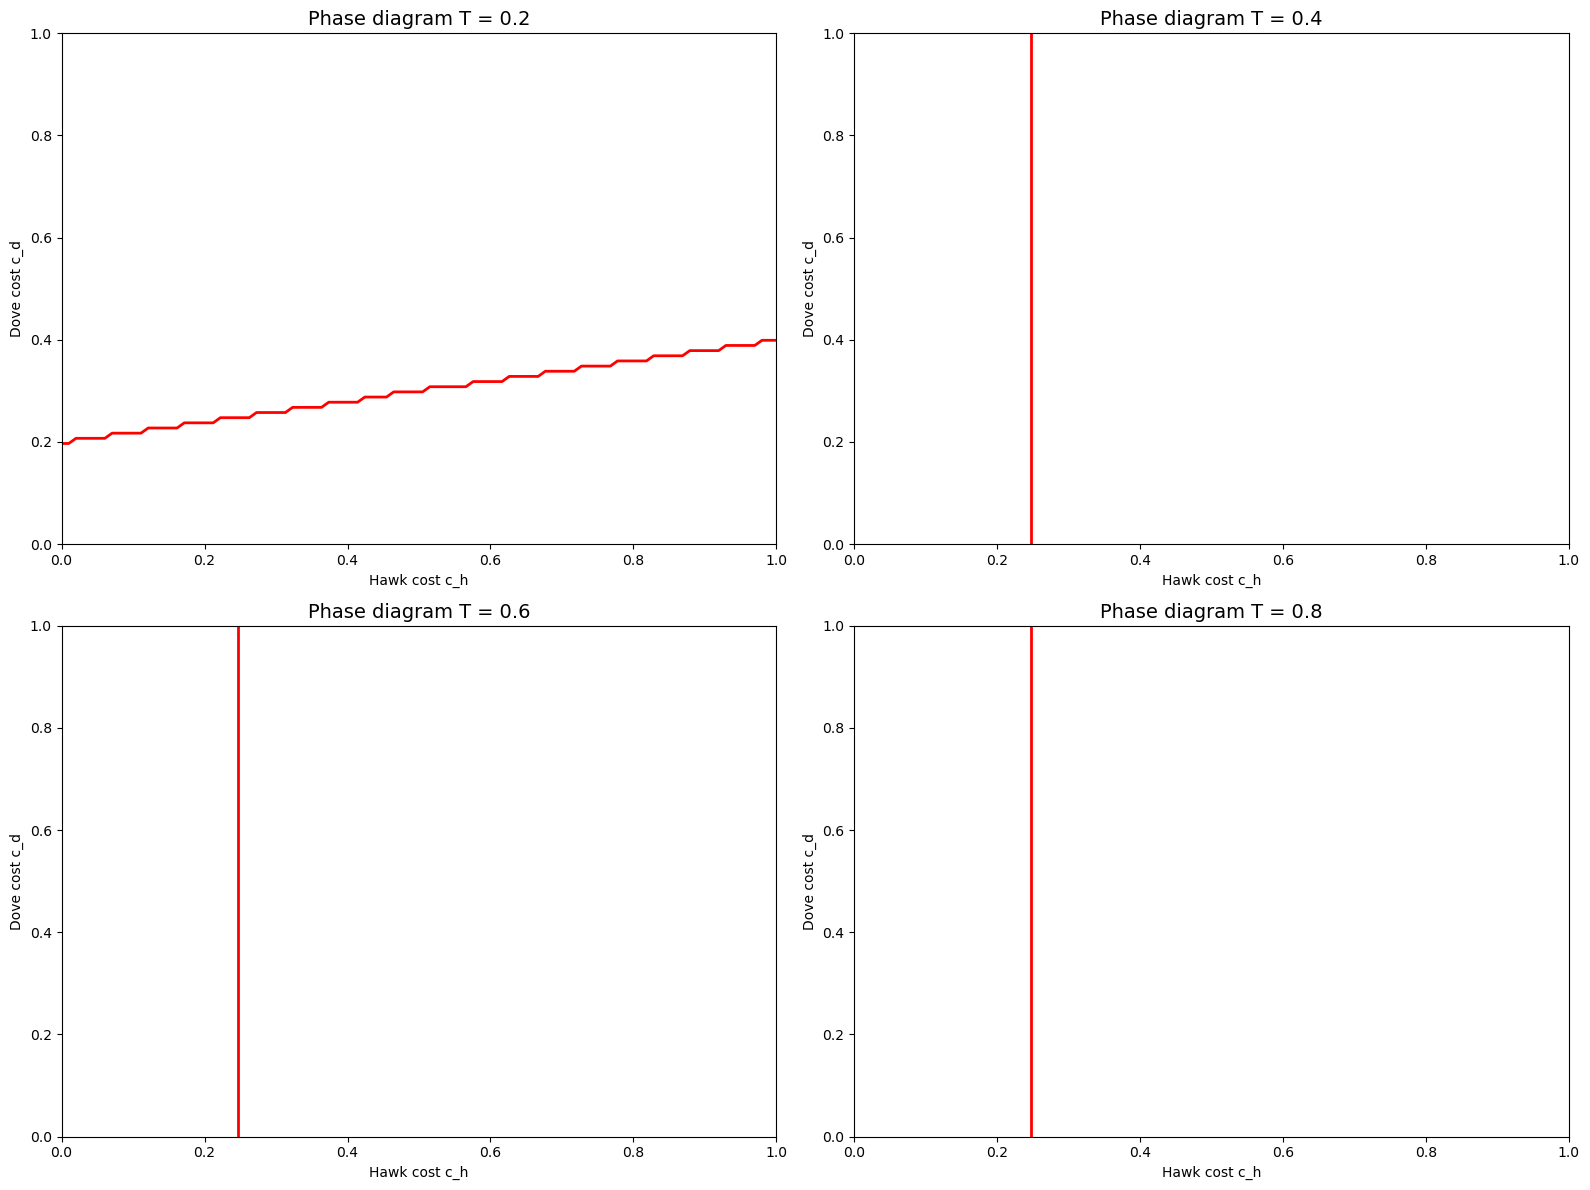

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the payoff functions
def P_H_T(amount_doves, c_h, T, N, R=1.0):
    P_H = 0
    amount_hawks = N - 1 - amount_doves
    total_hawks = amount_hawks + 1
    if amount_doves / N < T:
        P_H = (R - amount_hawks * c_h) / total_hawks
    return P_H

def P_D_T(amount_doves, c_d, T, N, R=1.0):
    P_D = 0
    amount_hawks = N - amount_doves
    if amount_doves / N >= T:
        P_D = (R - (amount_hawks * c_d)) / amount_doves
    return P_D

# Parameters
N = 5
R = 1.0
c_h_values = np.linspace(0, 1, n_steps)
c_d_values = np.linspace(0, 1, n_steps)
T_list = [0.2, 0.4, 0.6, 0.8]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, T in enumerate(T_list):
    phase_diagram = np.zeros((n_steps, n_steps), dtype=int)

    for i, c_h in enumerate(c_h_values):
        for j, c_d in enumerate(c_d_values):
            doves_can_invade = False
            hawks_can_invade = False

            # Favor 1 Hawk among Doves
            if (P_D_T(N, c_d, T, N, R) - P_H_T(N - 1, c_h, T, N, R)) < 0:
                hawks_can_invade = True

            # Favor 1 Dove among Hawks
            if (P_D_T(1, c_d, T, N, R) - P_H_T(0, c_h, T, N, R)) > 0:
                doves_can_invade = True

            if hawks_can_invade and not doves_can_invade:
                phase_diagram[i, j] = 1
            if doves_can_invade and not hawks_can_invade:
                phase_diagram[i, j] = 2
            if doves_can_invade and hawks_can_invade:
                phase_diagram[i, j] = 3

    # Visualize the boundaries for this T
    c_h_values = np.linspace(0, 1, n_steps)
    c_d_values = np.linspace(0, 1, n_steps)
    CH, CD = np.meshgrid(c_h_values, c_d_values, indexing='ij')

    region_labels = np.unique(phase_diagram)
    boundary_levels = 0.5 * (region_labels[:-1] + region_labels[1:])

    ax = axes[idx]
    CS = ax.contour(CH, CD, phase_diagram, levels=boundary_levels, colors='r', linewidths=2)
    ax.set_title(f"Phase diagram T = {T}", fontsize=14)
    ax.set_xlabel("Hawk cost c_h")
    ax.set_ylabel("Dove cost c_d")

# Adjust layout
plt.tight_layout()
plt.show()

#Finite populations
## Formulae for finite populations

Let $k$ be the number of doves in the total population.

Average fitness of hawks : $ f_H(k) = \sum_{i = 0}^{N - 1} \frac{\binom{k}{i} \binom{Z - k - 1}{N - i - 1}}{\binom{Z - 1}{N - 1}} P_H(i)$

Average fitness of doves : $ f_D(k) = \sum_{i = 0}^{N - 1} \frac{\binom{k-1}{i} \binom{Z - k}{N - i - 1}}{\binom{Z - 1}{N - 1}} P_D(i + 1)$ **research why i+1**

Gradient of selection in finite populations is given by: $ G(k) = T^+(k) - T^-(k) = \frac{k}{Z} \frac{Z - k}{Z} \tan h  (\frac{w}{2} ( f_D(k) - f_H(k)))$


In [26]:
# define the parameters
R = 1.0 #reward
N = 5 #sample size
Z = 100 #total population size
w = 100
n_steps = 100

# Average fitness of hawks
def avg_fitness_hawks(k, T, cost_hawks): #with k = nr of doves in the total population
  def payoff_hawks(nr_doves):
    # is i nr of doves or nr of hawks?
    nr_hawks = N - nr_doves
    if (nr_doves/N) < T : # NOTE TO SELF: here ze use the number of hawks/doves in the sample of size N, dus niet in de gehele populatie
       #or is i in the formula the nr of doves in both formulas?
       payoff = (R - ((nr_hawks - 1) * cost_hawks)) / nr_hawks
       return payoff
    else: return 0

  sum = 0
  for i in range(N):
    numerator = comb(k, i) * comb(Z-k-1, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_hawks(i)
  return sum

# Average fitness of doves
def avg_fitness_doves(k, T, cost_doves): #with k = nr of doves in the total population
  def payoff_doves(nr_doves):
    # is i nr of doves or nr of hawks?
    nr_hawks = N - nr_doves
    if (nr_doves/N) >= T : # NOTE TO SELF: here ze use the number of hawks/doves in the sample of size N, dus niet in de gehele populatie
       #or is i in the formula the nr of doves in both formulas?
       payoff = (R - (nr_hawks * cost_doves)) / nr_doves
       return payoff
    else: return 0

  sum = 0
  for i in range(N):
    numerator = comb(k-1, i) * comb(Z-k, N-i-1)
    denominator = comb(Z-1, N-1)
    sum += (numerator / denominator) * payoff_doves(i+1)
  return sum

#gradient of selection in finite populations
def gradient_selection_finite(k, T, cost_doves, cost_hawks):
#probablility population increase T_plus
  def T_plus(k): #with k = nr of doves in the total population
    factor_1 = k/Z
    factor_2 = (Z-k)/Z
    factor_3_exponent = w * (avg_fitness_doves(k, T, cost_doves) - avg_fitness_hawks(k, T, cost_hawks))
    factor_3 = 1/(1 + math.exp((factor_3_exponent)))
    return (factor_1 * factor_2 * factor_3)

  #probablility population decrease T_min
  def T_min(k): #with k = nr of doves in the total population
    factor_1 = k/Z
    factor_2 = (Z-k)/Z
    factor_3_exponent = w * (avg_fitness_doves(k, T, cost_doves) - avg_fitness_hawks(k, T, cost_hawks))
    factor_3 = 1/(1 + math.exp((-factor_3_exponent)))
    return (factor_1 * factor_2 * factor_3)

  return (T_plus(k) - T_min(k))

In [27]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

##Fig 5
Equilibria of the N-person Hawk-Dove Game with threshold in finite populations.

Fraction of doves $k*/Z$ in the equilibrium as a function of the hawks' cost $C_{H}$ (top) and doves' cost $C_{D}$ (bottom)
- for a sample size of $N=1$ in a finite population of $Z=100$.
- Solid (dashed) points represent stable (bistable) points, whereas dashed lines represent different doves' costs: red, blue, and grey lines correspond to $C_{D} = 0.2$, $0.5$, and $0.8$ respectively.
- In the bottom panels, red blue and grey symbols represent hawks' cost  $C_{H} = 0.2$, $0.5$, and $0.8$ respectively.
- Other parameters are $R=1$, $w=1$.


In [28]:
def figure5_toprow(T, c_d):

    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []


    for index, c_h in enumerate(hawk_cost):

        x_dot = np.empty(n_steps)

        for i in range(len(dove_frequency)):
            frac_doves = dove_frequency[i]
            total_nr_doves = frac_doves * Z
            #fitness_doves = avg_fitness_doves(total_nr_doves, T, c_d) # k, T , cost_doeves
            #fitness_hawks = avg_fitness_hawks(total_nr_doves, T, c_h)
            x_dot[i] = gradient_selection_finite(total_nr_doves, T, c_d, c_h)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        hawk_cost_answer.extend([c_h] * len(equilibria))


    return fraction_dove, hawk_cost_answer

In [29]:
def figure5_bottomrow(T, c_h):

    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    fraction_dove_answer = []

    for index, c_d in enumerate(dove_cost):

        x_dot =  np.empty(n_steps)

        for i in range(len(dove_frequency)):
            frac_doves = dove_frequency[i]
            total_nr_doves = frac_doves * Z
            #fitness_doves = average_fitness_doves(N, x, c_d, T)
            #fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = gradient_selection_finite(total_nr_doves, T, c_d, c_h)

        equilibria = find_equilibria_indexes(x_dot)
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        fraction_dove_answer.extend([c_d] * len(equilibria))

    return fraction_dove, fraction_dove_answer

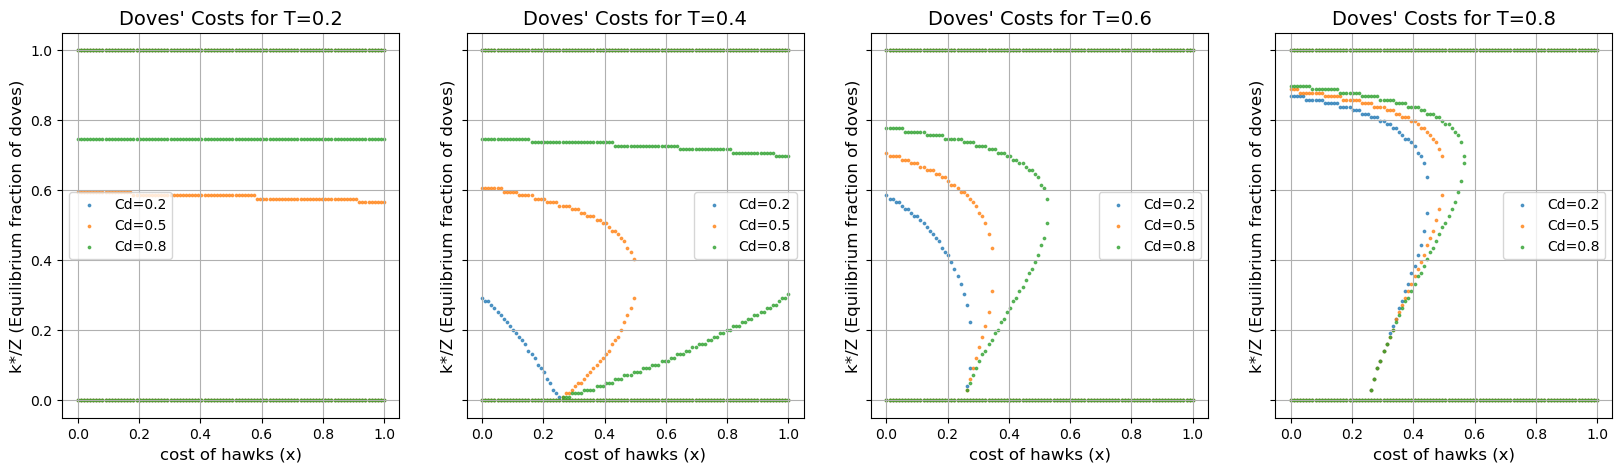

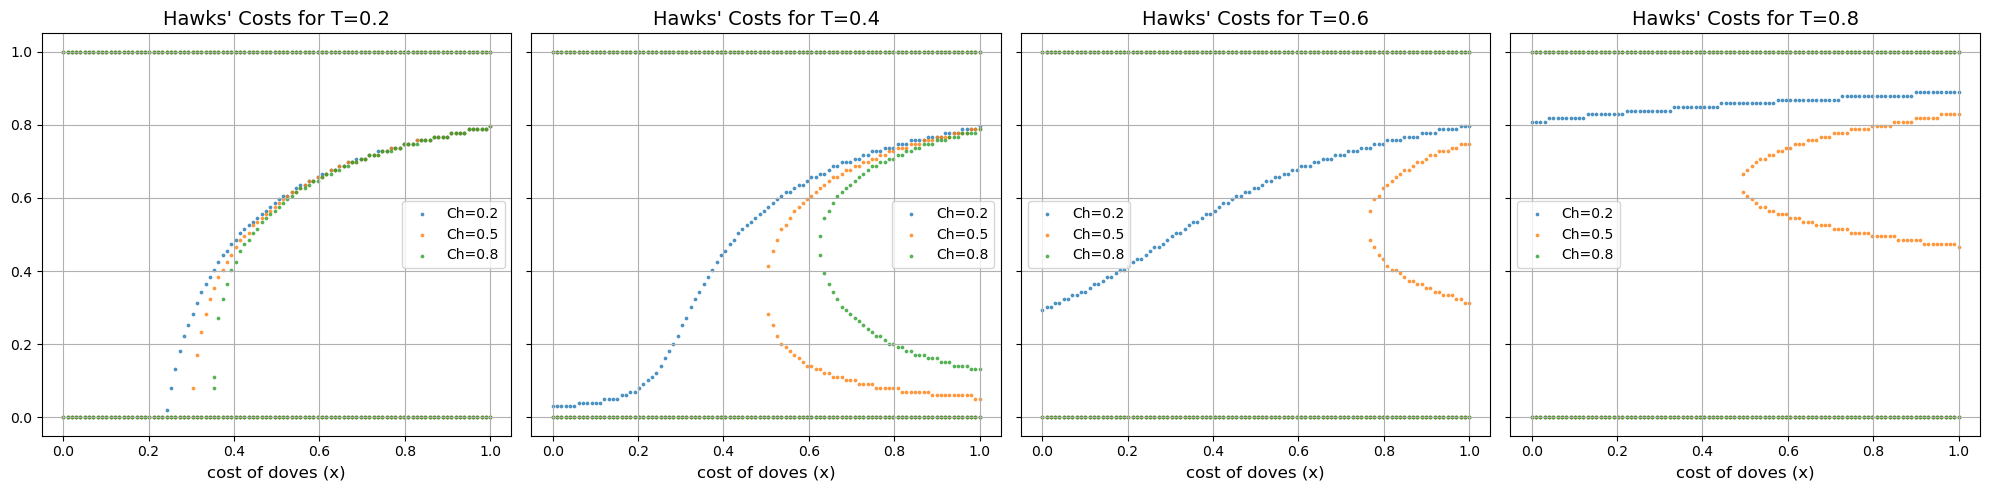

In [30]:
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

def plot_figure5_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):


        #Doves
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure5_toprow(T, c_d)
            axes[t_idx].scatter(x_as, y_as, label=Doves_Costs_labels[d_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of hawks (x)", fontsize=12)
        axes[t_idx].set_ylabel("k*/Z (Equilibrium fraction of doves)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)



    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []

    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure5_bottomrow(T, c_h)
            axes[t_idx].scatter(x_as, y_as, label=Hawks_Costs_labels[h_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of doves (x)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)

    plt.tight_layout()
    plt.show()

plot_figure5_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)